## Series Temporales - Trabajo Práctico
### Alumna: Ariadna Garmendia

### Tema: Análisis de cantidad de pasajeros que pasaron por los molinetes del subte en la Ciudad Autónoma de Buenos Aires entre 2017 y 2019.

### MODELO LA SERIE CON UNA RED NEURONAL LONG SHORT TERM MEMORY (LSTM)

#### Código fuente basado en el siguiente tutorial: https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scripts.import_data import data
from scripts.my_encoding import generate_cyclical_features, onehot_encode
from scripts.my_dataset_split import train_val_test_split
from scripts.nn_model import LSTMModel
from scripts.nn_optim import Optimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [92]:
#Importo mi dataset
molinetes,_,_,_= data()

In [93]:
molinetes.head()

,total
fecha,
2017-01-01,86802.0
2017-01-02,842897.0
2017-01-03,1023625.0
2017-01-04,512874.0
2017-01-05,204710.0


#### Paso 1: Creo el dataframe de features para entrenar la red neuronal

In [94]:
df_features = molinetes.copy()
df_features = df_features.reset_index()
df_features['fecha'] = df_features['fecha'].astype('datetime64')

In [95]:
# Extraigo features de la fecha
df_features = (
                df_features
                .assign(day = df_features.fecha.dt.day)
                .assign(month = df_features.fecha.dt.month)
                .assign(day_of_week = df_features.fecha.dt.dayofweek) 
                .assign(year = df_features.fecha.dt.year)
              )

In [96]:
# Verifico como quedaron los nuevos features
df_features.head()

,fecha,total,day,month,day_of_week,year
0,2017-01-01,86802.0,1,1,6,2017
1,2017-01-02,842897.0,2,1,0,2017
2,2017-01-03,1023625.0,3,1,1,2017
3,2017-01-04,512874.0,4,1,2,2017
4,2017-01-05,204710.0,5,1,3,2017


In [97]:
# Agrego columna 'feriado'
df_features['feriado'] = 0
df_features.loc[((df_features['day']==1) & (df_features['month']==1)), 'feriado'] = 1 # 1 Enero
df_features.loc[((df_features['day']==27) & (df_features['month']==2) & (df_features['year']==2017)), 'feriado'] = 1 # Carnaval
df_features.loc[((df_features['day']==28) & (df_features['month']==2) & (df_features['year']==2017)), 'feriado'] = 1 # Carnaval
df_features.loc[((df_features['day']==12) & (df_features['month']==2) & (df_features['year']==2018)), 'feriado'] = 1 # Carnaval
df_features.loc[((df_features['day']==13) & (df_features['month']==2) & (df_features['year']==2018)), 'feriado'] = 1 # Carnaval
df_features.loc[((df_features['day']==4) & (df_features['month']==3) & (df_features['year']==2019)), 'feriado'] = 1 # Carnaval
df_features.loc[((df_features['day']==5) & (df_features['month']==3) & (df_features['year']==2019)), 'feriado'] = 1 # Carnaval
df_features.loc[((df_features['day']==24) & (df_features['month']==3)), 'feriado'] = 1 # Memoria por la Verdad y la Justicia
df_features.loc[((df_features['day']==2) & (df_features['month']==4)), 'feriado'] = 1 # Caídos y Veteranos de Malvinas
df_features.loc[((df_features['day']==1) & (df_features['month']==5)), 'feriado'] = 1 # Dia del Trabajador
df_features.loc[((df_features['day']==25) & (df_features['month']==5)), 'feriado'] = 1 # Revolución de Mayo
df_features.loc[((df_features['day']==20) & (df_features['month']==6)), 'feriado'] = 1 # Conmem. muerte Gral Belgrano
df_features.loc[((df_features['day']==9) & (df_features['month']==7)), 'feriado'] = 1 # Día de la Independencia
df_features.loc[((df_features['day']==17) & (df_features['month']==8)), 'feriado'] = 1 # Conmem. muerte Gral San Martín
df_features.loc[((df_features['day']==20) & (df_features['month']==11)), 'feriado'] = 1 # Día de la Soberanía Nacional
df_features.loc[((df_features['day']==8) & (df_features['month']==12)), 'feriado'] = 1 # Inmaculada Concepción
df_features.loc[((df_features['day']==25) & (df_features['month']==12)), 'feriado'] = 1 # Navidad


In [98]:
# Remuevo la columna fecha
df_features.drop(['fecha'], axis=1, inplace=True)

In [99]:
df_features.head()

,total,day,month,day_of_week,year,feriado
0,86802.0,1,1,6,2017,1
1,842897.0,2,1,0,2017,0
2,1023625.0,3,1,1,2017,0
3,512874.0,4,1,2,2017,0
4,204710.0,5,1,3,2017,0


#### Paso 2: Split del dataset en Train, Test y Validation (80/10/10)

In [100]:
# Hago el split usando mi función (ver carpeta 'scripts')
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features, 'total', 0.1)

In [101]:
# Verifico dimensiones
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((872, 5), (110, 5), (110, 5), (872, 1), (110, 1), (110, 1))

#### Paso 3: Scaling

In [102]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

y_train_sc = scaler.fit_transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)



#### Paso 4: Dataloaders

In [103]:
# Creo Dataloaders
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_sc)
train_targets = torch.Tensor(y_train_sc)
val_features = torch.Tensor(X_val_sc)
val_targets = torch.Tensor(y_val_sc)
test_features = torch.Tensor(X_test_sc)
test_targets = torch.Tensor(y_test_sc)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

#### Paso 5: Training

[1/1000] Training loss: 0.2327	 Validation loss: 0.2026
[2/1000] Training loss: 0.1553	 Validation loss: 0.1195
[3/1000] Training loss: 0.0901	 Validation loss: 0.0920
[4/1000] Training loss: 0.0831	 Validation loss: 0.0842
[5/1000] Training loss: 0.0790	 Validation loss: 0.0821
[6/1000] Training loss: 0.0772	 Validation loss: 0.0802
[7/1000] Training loss: 0.0761	 Validation loss: 0.0777
[8/1000] Training loss: 0.0735	 Validation loss: 0.0747
[9/1000] Training loss: 0.0709	 Validation loss: 0.0710
[10/1000] Training loss: 0.0681	 Validation loss: 0.0661
[11/1000] Training loss: 0.0645	 Validation loss: 0.0603
[12/1000] Training loss: 0.0613	 Validation loss: 0.0545
[13/1000] Training loss: 0.0591	 Validation loss: 0.0501
[14/1000] Training loss: 0.0571	 Validation loss: 0.0477
[15/1000] Training loss: 0.0568	 Validation loss: 0.0467
[16/1000] Training loss: 0.0562	 Validation loss: 0.0461
[17/1000] Training loss: 0.0560	 Validation loss: 0.0456
[18/1000] Training loss: 0.0551	 Validat

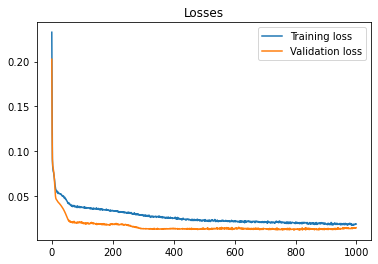

In [104]:
# Parametros del modelo
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 1000
learning_rate = 1e-3
weight_decay = 1e-6

# Defino Modelo
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)

# Defino Loss function
loss_fn = torch.nn.MSELoss(reduction="mean")

# Defino Optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Instancio clase para realizar el entrenamiento y evaluación
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()



#### Paso 6: Evaluación del modelo con el dataset de Test (110 muestras finales del dataset)

In [105]:
prediccion, original = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

In [106]:
# Funciones para re-escalar las predicciones (porque los datos estaban transformados con un scaler)
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"original": vals, "prediccion": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["original", "prediccion"]])
    return df_result


df_result = format_predictions(prediccion, original, X_test, scaler)
df_result

,original,prediccion
982,1.334808e+06,1.385278e+06
983,5.552040e+05,5.836778e+05
984,2.900580e+05,3.040922e+05
985,1.281970e+06,1.008840e+06
986,1.292380e+06,1.165990e+06
...,...,...
1087,1.080310e+06,9.139832e+05
1088,4.080940e+05,3.722842e+05
1089,2.130810e+05,2.837176e+05
1090,8.650960e+05,7.665791e+05


In [107]:
# Preparo resultados para graficar
df_fecha = molinetes.copy()
df_fecha = df_fecha.reset_index()
df_result['fecha'] = df_fecha['fecha'].astype('datetime64')
df_result = df_result.set_index('fecha')

df_result.head()

,original,prediccion
fecha,,
2019-09-13,1334808.0,1.385278e+06
2019-09-14,555204.0,5.836778e+05
2019-09-15,290058.0,3.040922e+05
2019-09-16,1281970.0,1.008840e+06
2019-09-17,1292380.0,1.165990e+06


Text(0.5, 1.0, 'Predicción con el dataset de Test')

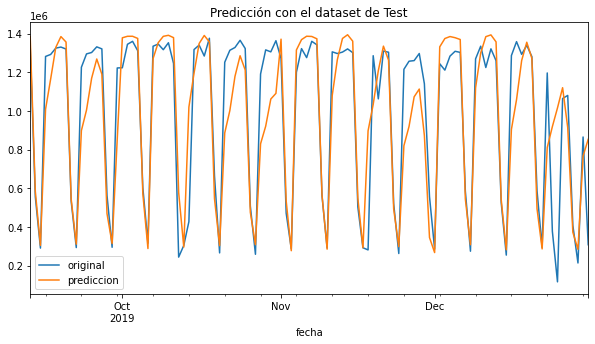

In [108]:
# Plot
df_result.plot(figsize=[10,5])
plt.title("Predicción con el dataset de Test")


#### Paso 8: Métricas de error

In [109]:
# Función para calcular métricas
def calculate_metrics(df, y_true, y_pred):
    result_metrics = {'mae' : mean_absolute_error(df[y_true], df[y_pred]),
                      'rmse' : mean_squared_error(df[y_true], df[y_pred]) ** 0.5,
                      'r2' : r2_score(df[y_true], df[y_pred])}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics


In [110]:
result_metrics = calculate_metrics(df_result, 'original', 'prediccion')

Mean Absolute Error:        135925.77
Root Mean Squared Error:    207553.568911739
R^2 Score:                  0.7715062252442666
